# Preparing Data
First up, importing all the necessary libraries. The main ones we'll be using are:

* PyTorch for creating the models
* spaCy to assist in the tokenization of the data
* torchtext to provider some helper functions
* datasets to load and manipulate our data
* evaluate for calculating metrics

In [1]:
import spacy
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
import numpy as np
import random
import torch.nn.functional as F
import lightning as L
import datasets
import torchtext


/Users/volageek/miniconda3/envs/mltf/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/volageek/miniconda3/envs/mltf/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/volageek/miniconda3/envs/mltf/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarni

In [2]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Setting up the Data

In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [5]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

In [6]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

#Tokenizers
Next, we'll load the spaCy models that contain the tokenizers.

A tokenizer is used to turn a string into a list of tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is not a word. We could say "!" is punctuation, but the term token is more general and covers: words, punctuation, numbers and any special symbols.

In [7]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [8]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [9]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [10]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

In [11]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

# Vocabularies

Ideally, we want our model to be able to handle unknown tokens by learning to use the context around them to make translations. The only way it can learn that is if we also have unknown tokens in the training set. Hence, when creating our vocabularies with build_vocab_from_iterator, we use the min_freq argument to not create an index for tokens which appear less than min_freq times in our training set. In other words, when using the vocabulary, any token which does not appear at least twice in our training set will get replaced by the unknown token index when converting tokens to indices.

In [12]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

We can get the first ten tokens in our vocabulary (indices 0 to 9) using the `get_itos` method, where itos = "int to string", which returns a list of tokens.

In [13]:
 en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [14]:
de_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',']

We can get the index from a given token using the `get_stoi` (stoi = " string to int) method.

In [15]:
en_vocab.get_stoi()["the"]

7

In [16]:
len(en_vocab), len(de_vocab)

(5893, 7853)

In [17]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [18]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

Another useful feature of the vocabulary is the `lookup_indices` method. This takes in a list of tokens and returns a list of indices. In the below example we can see the token "crime" does not exist in our vocabulary so is coverted to the index of the <unk> token, zero, which we passed to the set_default_index method.

In [19]:
tokens = ["i", "love", "watching", "crime", "shows"]
en_vocab.lookup_indices(tokens)

[956, 2169, 173, 0, 821]

In [20]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', 'watching', '<unk>', 'shows']

In [21]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [22]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [23]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>'],
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3]}

The with_format method converts features indicated by the columns argument to a given type. Here, we specify the type as "torch" (for PyTorch) and the columns to be "en_ids" and "de_ids" (the features which we want to convert to PyTorch tensors). By default, with_format will remove any features not in the list of features passed to columns. We want to keep those features, which we can do with output_all_columns=True.


In [24]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [25]:
train_data[0]

{'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
            3]),
 'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
         3171,    4,    3]),
 'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

# Data Loaders
The final step of preparing the data is to create the data loaders. These can be iterated upon to return a batch of data, each batch being a dictionary containing the numericalized English and German sentences (which have also been padded) as PyTorch tensors.

First, we need to create a function that collates, i.e. combines, a batch of examples into a batch. The collate_fn below takes a "batch" as input (a list of examples), we then separate out the English and German indices for each example in the batch, and pass each one to the pad_sequence function. pad_sequence takes a list of tensors, pads each one to the length of the longest tensor using the padding_value (which we set to pad_index, the index of our <pad> token) and then returns a [max length, batch size] shaped tensor, where batch size is the number of examples in the batch and max length is the length of the longest tensor in the batch. We put each tensor into a dictionary and then return it.

The get_collate_fn takes in the padding token index and returns the collate_fn defined inside it. This technique, of defining a function inside another and returning it, is known as a closure. It allows the collate_fn to continually use the value of pad_index it was created with without creating a class or using global variables.

In [26]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [27]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [28]:
batch_size = 32

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

# Building the Model

In [128]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden

In [129]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

In [130]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pytorch_lightning as pl

class Seq2Seq(L.LightningModule):
    def __init__(self, encoder, decoder, pad_index, teacher_forcing_ratio=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_index
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self._loss = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
        self.learning_rate = 0.0005
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)

    def forward(self, src, trg):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < self.teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

    def training_step(self, batch, batch_idx):
        src = batch["de_ids"].to(self.device)
        trg = batch["en_ids"].to(self.device)
        
        optimizer = self.optimizers()
        optimizer.zero_grad()
        
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = self._loss(output, trg)
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        src = batch["de_ids"].to(self.device)
        trg = batch["en_ids"].to(self.device)
        
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = self._loss(output, trg)
        self.log('val_loss', loss)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

In [241]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, pad_index, teacher_forcing_ratio=0.5).to(device)

cpu


In [242]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (_loss): CrossEntropyLoss()
)

In [279]:
trainer = L.Trainer(limit_train_batches=100, max_epochs=25)
trainer.fit(model, train_dataloaders=train_data_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode
----------------------------------------------------
0 | encoder | Encoder          | 4.9 M  | eval
1 | decoder | Decoder          | 15.6 M | eval
2 | _loss   | CrossEntropyLoss | 0      | eval
----------------------------------------------------
20.5 M    Trainable params
0         Non-trainable params
20.5 M    Total params
82.074    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [280]:
import torch

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    epoch_loss = 0.0
    
    with torch.no_grad():
        for batch in data_loader:
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            
            # Forward pass
            output = model(src, trg)  # Turn off teacher forcing
            
            # Compute loss
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)  # Remove <sos> token for loss calculation
            trg = trg[1:].view(-1)  # Remove <sos> token for target
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(data_loader)  # Average loss over all batches

In [281]:
test_loss = evaluate_fn(model, test_data_loader, nn.CrossEntropyLoss(ignore_index=pad_index), device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 2.6032


In [282]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

In [283]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [284]:
import matplotlib.pyplot as plt
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()


In [285]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

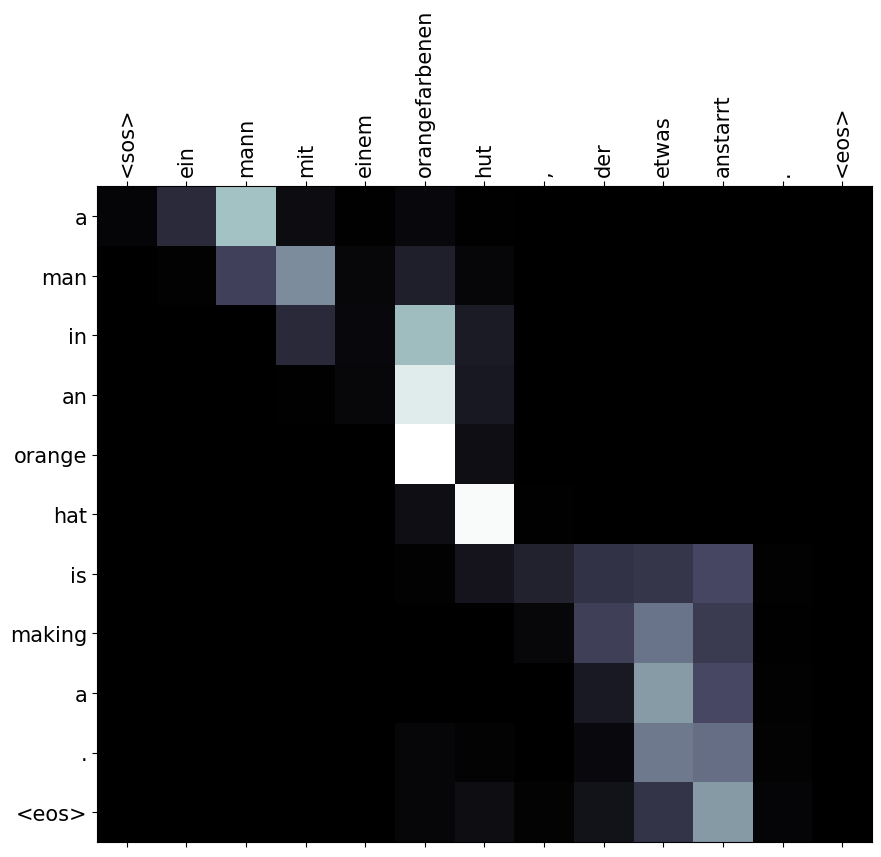

In [286]:
plot_attention(sentence_tokens, translation, attention)

In [287]:
sentence = "Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt."
en_tokens, de_tokens, attentions = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower=True,
    sos_token="<sos>",
    eos_token="<eos>",
    device=device,
    max_output_length=25,
)

print(f"Input (DE): {' '.join(de_tokens)}")
print(f"Translated Output (EN): {' '.join(en_tokens)}")

Input (DE): <sos> ein mann mit einem orangefarbenen hut , der etwas anstarrt . <eos>
Translated Output (EN): <sos> a man in an orange hat is making a . <eos>


In [290]:
torch.save(model.state_dict(), 'saved_paths/seq2seq_model.pth')
torch.save(de_vocab, 'saved_paths/de_vocab.pt')
torch.save(en_vocab, 'saved_paths/en_vocab.pt')